[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RichardJPovinelli/home/blob/main/Evolutionary_Computation_Class/Parameter_Tuning_Lab.ipynb)
# Parameter Tuning Lab: REVAC, TPE (Optuna), and PBT — on OneMax

**Goal:** Compare three ways to choose EA hyperparameters.  
- REVAC-style tuner: population-based refinement
- TPE (Optuna): model-based density estimation
- PBT: online adaptation during training

**Task:** Evolve bitstrings to maximize OneMax (sum of bits).

In [1]:
import numpy as np
import random
import optuna
import matplotlib.pyplot as plt
rng = np.random.default_rng(42)
random.seed(42)

In [2]:
# Colab setup (optional)
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    # Install required packages that might be missing on Colab VMs without using notebook magics
    try:
        import optuna  # noqa: F401
    except Exception:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "optuna"])
        import optuna  # noqa: F401
    # Ensure inline plotting (skip IPython magic; use matplotlib API)
    try:
        import matplotlib
        matplotlib.use("Agg")  # fallback-safe; notebook backends will override if available
    except Exception:
        pass

## 1️⃣ Define the One-Max Problem and GA

In [3]:
def one_max(bits): return int(np.sum(bits))
def random_bits(n): return rng.integers(0, 2, size=n)

def crossover_1point(parent_a,parent_b):
    if len(parent_a)<2: return parent_a.copy()
    pt=rng.integers(1,len(parent_a))
    return np.concatenate([parent_a[:pt],parent_b[pt:]])

def mutate_bitflip(bits,mutation_rate):
    mask=rng.random(bits.shape[0])<mutation_rate
    out=bits.copy()
    out[mask]^=1
    return out

def run_ga(population_size,crossover_rate,mutation_rate,generations=60,genome_length=1024): #64):
    population=[random_bits(genome_length) for _ in range(population_size)]
    best_hist=[]
    for _ in range(generations):
        fitnesses=[one_max(individual) for individual in population]
        parents=[population[i] for i in np.argsort(fitnesses)[-population_size//2:]]
        offspring=[]
        while len(offspring)<population_size:
            parent_a,parent_b=random.sample(parents,2)
            child=crossover_1point(parent_a,parent_b) if random.random()<crossover_rate else parent_a.copy()
            child=mutate_bitflip(child,mutation_rate); offspring.append(child)
        population=offspring; best_hist.append(max(fitnesses))
    return max(best_hist), best_hist

## 2️⃣ REVAC-Style Tuner

In [4]:
def revac_tuner(eval_fn,bounds,population_size=10,iterations=40,shrink=0.3,seed=7,progress_callback=None):
    rng_local=np.random.default_rng(seed)
    def sample_one():
        params={}
        for param_name,(low,high,kind) in bounds.items():
            params[param_name]=int(rng_local.integers(low,high+1)) if kind=='int' else float(rng_local.uniform(low,high))
        return params
    population=[sample_one() for _ in range(population_size)]
    tuning_history=[]
    for trial in range(iterations):
        results=[(eval_fn(params),params) for params in population]
        results.sort(key=lambda x:x[0],reverse=True)
        winners=[params for _,params in results[:population_size//2]]
        best_score,best_params=results[0]
        dispersion={}
        for param_name,(low,high,kind) in bounds.items():
            values=np.array([w[param_name] for w in winners],float)
            dispersion[param_name]=values.std()/(high-low+1e-9)
        proposal_std={param_name:max(1e-6,(high-low)*shrink*(0.5+dispersion[param_name])) for param_name,(low,high,kind) in bounds.items()}
        new_population=[]
        for _ in range(population_size):
            parent=random.choice(winners); child={}
            for param_name,(low,high,kind) in bounds.items():
                val=rng_local.normal(parent[param_name],proposal_std[param_name])
                if kind=='int':
                    val=int(np.clip(round(val),low,high))
                else:
                    val=float(np.clip(val,low,high))
                child[param_name]=val
            new_population.append(child)
        population=new_population; tuning_history.append((trial,best_score,best_params,winners))
        if progress_callback is not None:
            progress_callback(trial,best_score,best_params)
    return tuning_history

In [5]:
bounds={'pop_size':(10,120,'int'),'cx_rate':(0.5,1.0,'float'),'mut_rate':(0.001,0.05,'float')}
def eval_fn(parameters): 
    return run_ga(int(parameters['pop_size']),parameters['cx_rate'],parameters['mut_rate'])[0]
def log_revac_progress(trial,best_score,best_params):
    pop_fmt=int(best_params.get('pop_size', best_params.get('population', 0)))
    cx_fmt=float(best_params['cx_rate'])
    mut_fmt=float(best_params['mut_rate'])
    display(f"[REVAC] trial {trial:02d} best={best_score} with parameters: pop_size={pop_fmt}, cx_rate={cx_fmt:.3g}, mut_rate={mut_fmt:.2e}")
revac_hist=revac_tuner(eval_fn,bounds,population_size=12,iterations=8,progress_callback=log_revac_progress)
revac_best=max(revac_hist,key=lambda x:x[1])
pop_fmt=int(revac_best[2]['pop_size'])
cx_fmt=float(revac_best[2]['cx_rate'])
mut_fmt=float(revac_best[2]['mut_rate'])
print(f"Best={revac_best[1]} with parameters: pop_size={pop_fmt}, cx_rate={cx_fmt:.3g}, mut_rate={mut_fmt:.2e}")
# revac_best

'[REVAC] trial 00 best=701 with parameters: pop_size=100, cx_rate=0.639, mut_rate=1.35e-02'

'[REVAC] trial 01 best=703 with parameters: pop_size=120, cx_rate=1, mut_rate=1.73e-02'

'[REVAC] trial 02 best=671 with parameters: pop_size=71, cx_rate=0.839, mut_rate=2.38e-02'

'[REVAC] trial 03 best=729 with parameters: pop_size=75, cx_rate=1, mut_rate=1.53e-02'

'[REVAC] trial 04 best=702 with parameters: pop_size=73, cx_rate=0.604, mut_rate=4.01e-03'

'[REVAC] trial 05 best=716 with parameters: pop_size=70, cx_rate=0.919, mut_rate=4.24e-03'

'[REVAC] trial 06 best=732 with parameters: pop_size=110, cx_rate=0.708, mut_rate=5.45e-03'

'[REVAC] trial 07 best=739 with parameters: pop_size=94, cx_rate=0.946, mut_rate=1.02e-02'

Best=739 with parameters: pop_size=94, cx_rate=0.946, mut_rate=1.02e-02


## 3️⃣ TPE (Optuna)

In [6]:
def objective(trial):
    pop_size=trial.suggest_int('pop_size',10,120)
    cx_rate=trial.suggest_float('cx_rate',0.5,1.0)
    mut_rate=trial.suggest_float('mut_rate',0.001,0.05)
    best,_=run_ga(pop_size,cx_rate,mut_rate)
    return best

study=optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=100)
tpe_best_val=study.best_value
tpe_best_val,study.best_params

[I 2025-11-05 06:41:07,415] A new study created in memory with name: no-name-c401e3c8-6368-42d4-bdbc-3c4809303b05
[I 2025-11-05 06:41:07,473] Trial 0 finished with value: 691.0 and parameters: {'pop_size': 120, 'cx_rate': 0.7130572898974812, 'mut_rate': 0.017353598285813492}. Best is trial 0 with value: 691.0.
[I 2025-11-05 06:41:07,479] Trial 1 finished with value: 603.0 and parameters: {'pop_size': 10, 'cx_rate': 0.515753514539262, 'mut_rate': 0.049964685595248776}. Best is trial 0 with value: 691.0.
[I 2025-11-05 06:41:07,535] Trial 2 finished with value: 642.0 and parameters: {'pop_size': 116, 'cx_rate': 0.597960686419182, 'mut_rate': 0.0339581546413204}. Best is trial 0 with value: 691.0.
[I 2025-11-05 06:41:07,573] Trial 3 finished with value: 659.0 and parameters: {'pop_size': 80, 'cx_rate': 0.5726514882345388, 'mut_rate': 0.02554688031177704}. Best is trial 0 with value: 691.0.
[I 2025-11-05 06:41:07,596] Trial 4 finished with value: 625.0 and parameters: {'pop_size': 47, 'cx_r

(745.0,
 {'pop_size': 101,
  'cx_rate': 0.9728209490020902,
  'mut_rate': 0.0027855317392391837})

## 4️⃣ PBT-Style GA

In [7]:
def pbt_ga(workers=6,pop_size=40,genome_length=64,gens=120,interval=10,jitter=0.2):
    populations=[[random_bits(genome_length) for _ in range(pop_size)] for _ in range(workers)]
    crossover_rates=rng.uniform(0.6,0.95,workers); mutation_rates=rng.uniform(0.002,0.04,workers)
    best_hist=[]; crossover_hist=[[float(crossover_rates[i])] for i in range(workers)]; mutation_hist=[[float(mutation_rates[i])] for i in range(workers)]
    for g in range(1,gens+1):
        worker_scores=[]
        for worker_index in range(workers):
            populations[worker_index],best=(run_ga_onegen(populations[worker_index],crossover_rates[worker_index],mutation_rates[worker_index]) if 'run_ga_onegen' in globals() else (populations[worker_index],[0]))
            best_val=max([one_max(ind) for ind in populations[worker_index]])
            worker_scores.append(best_val)
        best_hist.append(max(worker_scores))
        if g%interval==0:
            ranking=np.argsort(worker_scores)[::-1]; best_worker=ranking[0]; worst_workers=ranking[len(ranking)//2:]
            for worker_id in worst_workers:
                populations[worker_id]=[ind.copy() for ind in populations[best_worker]]
                crossover_rates[worker_id]=float(np.clip(crossover_rates[best_worker]*(1+rng.uniform(-jitter,jitter)),0.5,1.0))
                mutation_rates[worker_id]=float(np.clip(mutation_rates[best_worker]*(1+rng.uniform(-jitter,jitter)),0.0005,0.1))
        for i in range(workers):
            crossover_hist[i].append(float(crossover_rates[i])); mutation_hist[i].append(float(mutation_rates[i]))
    return {'best_hist':best_hist,'crossover_hist':crossover_hist,'mutation_hist':mutation_hist}

## 5️⃣ Compare Methods

In [8]:
pbt_res=pbt_ga()
revac_best_val=revac_best[1]
pbt_best_val=max(pbt_res['best_hist'])
print(f'Revac={revac_best_val}, TPE={tpe_best_val}, PBT={pbt_best_val}')

Revac=739, TPE=745.0, PBT=42


## Comparison

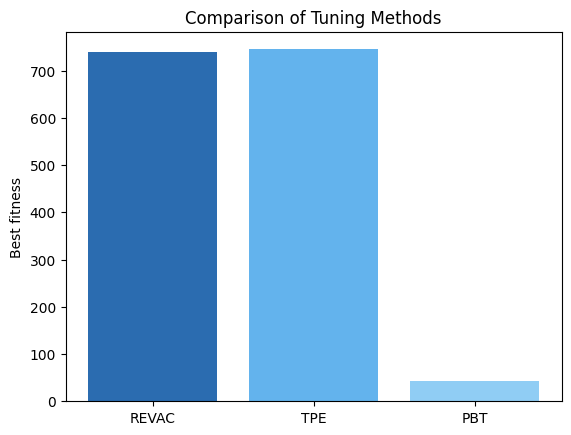

In [9]:
methods=['REVAC','TPE','PBT']; vals=[revac_best_val,tpe_best_val,pbt_best_val]
plt.bar(methods,vals,color=['#2b6cb0','#63b3ed','#90cdf4'])
plt.ylabel('Best fitness'); plt.title('Comparison of Tuning Methods'); plt.show()

- REVAC improves gradually; slower but interpretable.
- TPE jumps quickly to high performance; efficient under small budgets.
- PBT adapts online; robust under non-stationary conditions.